In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import print_function
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import h5py

In [2]:
def load_dataset(path_to_train, path_to_test):
    train_dataset = h5py.File(path_to_train)
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test)
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # y reshaped
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y

In [3]:
train_x, train_y, test_x, test_y = load_dataset("../../../Data/Happyhouse/train_happy.h5", "../../../Data/Happyhouse/test_happy.h5")

In [4]:
# Convert them to grayscale
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def graythem(train):
    newtrain = []
    for x in train:
        data = np.concatenate(rgb2gray(x), axis=0)
        newtrain.append(data)
    return newtrain

def gray2black(gray):
    if gray > 90:
        black = 1
    else:
        black = 0
    return black

def blackthem(train):
    newblack = []
    for x in train:
        newpix = []
        for pix in x:
            #print(pix)
            data = gray2black(pix)
            #print(data)
            newpix.append(data)
        newblack.append(newpix)
    return newblack

    

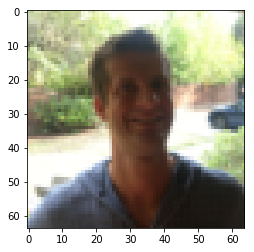

In [5]:
plt.imshow(train_x[1])

In [6]:
train_x.shape

(600, 64, 64, 3)

In [7]:
gray_train_x = graythem(train_x)

In [8]:
gray_test_x = graythem(test_x)

In [9]:
train_x[0].shape

(64, 64, 3)

In [10]:
gray_train_x[0].shape

(4096,)

In [11]:
train_y1 = train_y[0]

In [12]:
graytrain2 = [np.clip((x*1.5), 0, 255) for x in gray_train_x]

In [13]:
graytest = [np.clip((x*1.5), 0, 255) for x in gray_test_x]

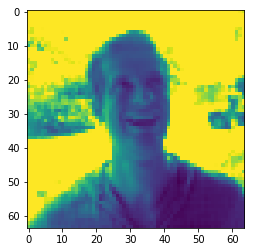

In [14]:
plt.imshow(graytrain2[3].reshape(64,64))

In [15]:
Xt = graytrain2
Xn = (Xt - np.min(Xt, 0)) / (np.max(Xt, 0) + 0.0001) 

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(Xn, train_y1, test_size=0.3, random_state=0)

In [17]:
Y_test.shape

(180,)

In [18]:
Y_test

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0])

In [19]:
sum(Y_test)

93

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression




# Set the logistic parameters by cross-validation
tuned_parameters = {'C': [1, 10, 100, 1000]}

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


import time

# initialize the RBM + Logistic Regression pipeline
rbm = BernoulliRBM()
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])
 

print ("SEARCHING RBM + LOGISTIC REGRESSION")
params = {
"rbm__learning_rate": [0.01, 0.001],
"rbm__n_iter": [40, 80, 100],
"rbm__n_components": [20, 50, 100, 100],
"logistic__C": [1.0]}
 
# perform a grid search over the parameter
start = time.time()
gs = GridSearchCV(classifier, params, n_jobs = -1, verbose = 1)
gs.fit(X_train, Y_train)
 
# print diagnostic information to the user and grab the
# best model
print ("\ndone in %0.3fs" % (time.time() - start))
print ("best score: %0.3f" % (gs.best_score_))
print ("RBM + LOGISTIC REGRESSION PARAMETERS")
bestParams = gs.best_estimator_.get_params()
 
# loop over the parameters and print each of them out
# so they can be manually set
for p in sorted(params.keys()):
    print ("\t %s: %f" % (p, bestParams[p]))

In [21]:
# Set up Models
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training


rbm.learning_rate = 0.01
rbm.n_iter = 100
rbm.n_components = 1000

logistic.C = 1000
logistic.kernal = 'linear'

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 1.
raw_pixel_classifier.fit(X_train, Y_train)


[BernoulliRBM] Iteration 1, pseudo-likelihood = -2257.14, time = 9.46s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -2356.94, time = 9.23s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -2283.34, time = 8.18s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -2193.45, time = 9.21s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -2368.90, time = 9.31s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -2370.67, time = 8.51s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2287.00, time = 8.07s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -2345.45, time = 8.99s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -2381.04, time = 8.52s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2232.95, time = 8.75s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -2191.42, time = 6.29s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2264.66, time = 5.64s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -2244.87, time = 5.87s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -2125.25, time = 8.60s
[

/home/ebicher/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ebicher/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))


Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        87
           1       0.95      0.90      0.93        93

   micro avg       0.93      0.93      0.93       180
   macro avg       0.93      0.93      0.93       180
weighted avg       0.93      0.93      0.93       180


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        87
           1       0.97      0.97      0.97        93

   micro avg       0.97      0.97      0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180




ValueError: num must be 1 <= num <= 300, not 301

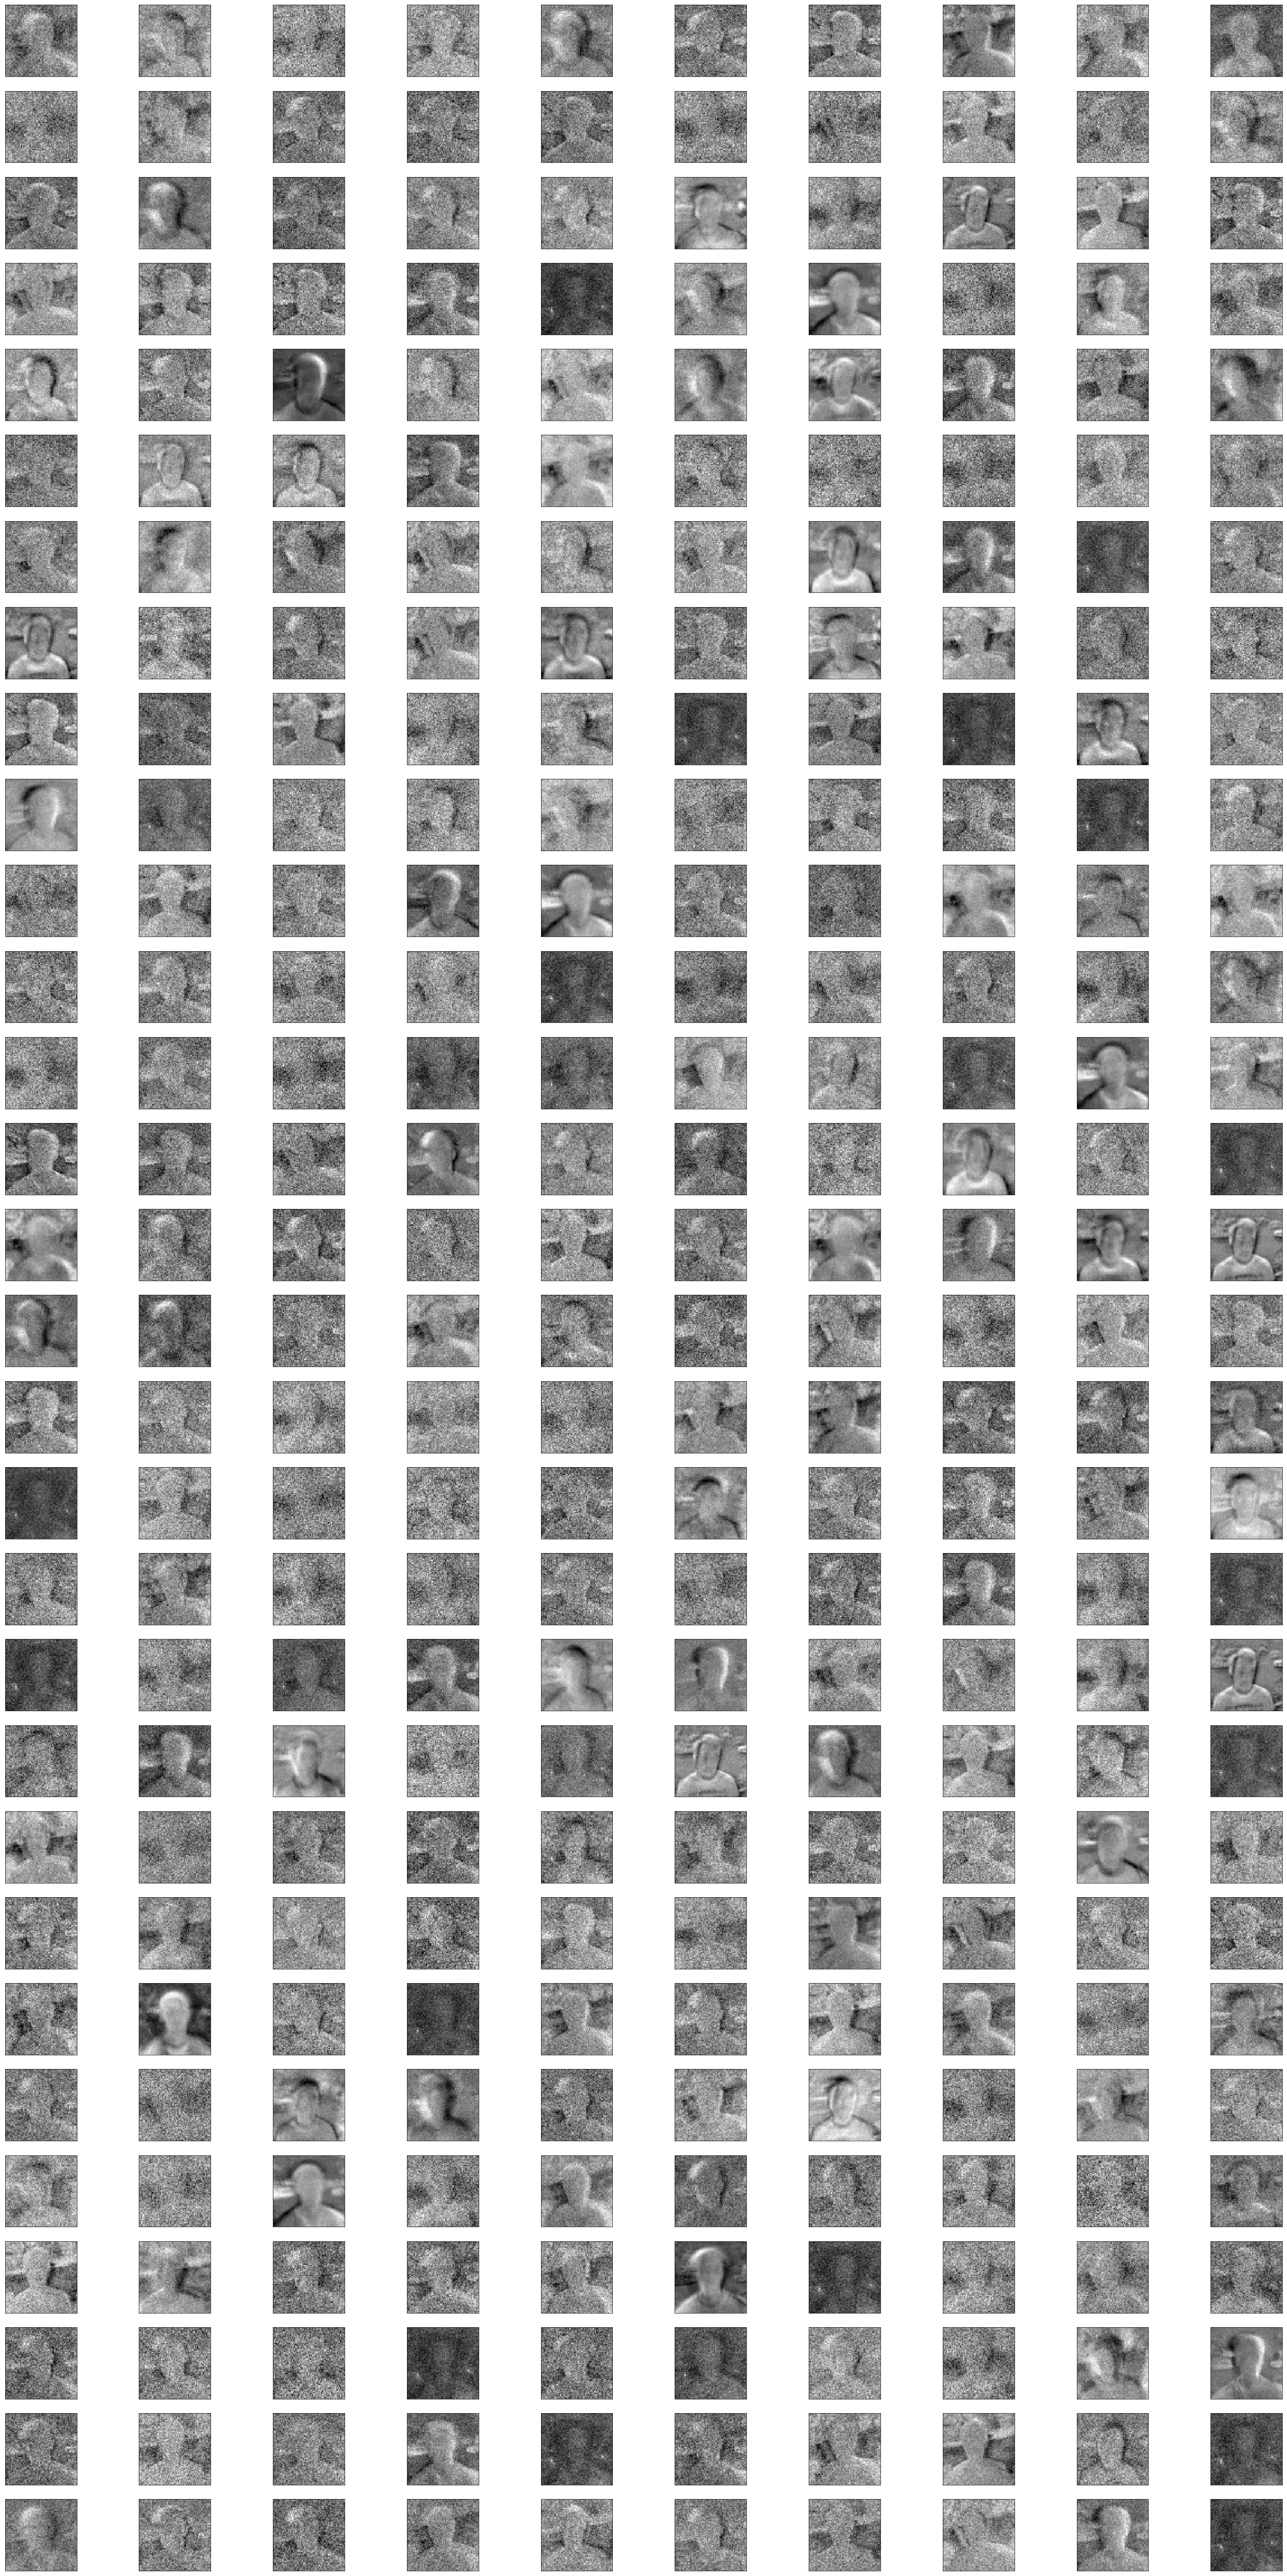

In [23]:

# #############################################################################
# Plotting

plt.figure(figsize=(50, 100))
for i, comp in enumerate(rbm.components_):
    plt.subplot(30, 10, i + 1)
    plt.imshow(comp.reshape((64, 64)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('20 components extracted by RBM', fontsize=16)
#plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [ ]:
fig, axs = plt.subplots(18,10, figsize=(20, 50), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(180):
    axs[i].imshow(X_test[i].reshape(64,64))
    axs[i].set_title(str(Y_pred[i]))
plt.show()